# XGBoost and Gas Fees

Modeling to predict the gas fees for two pools of data.

# When Using a Google Shared Drive

To mount a drive that is not yours but shared with you, you must:<br>
- go into Google Drive<br>
- select the DATASCI210 folder you want to use in Colab<br>
- Right click on the DATASCI210 folder<br>
- Select "Organize"<br>
- then "Add Shortcut"<br>
- then specify the shortcut to go into the "MyDrive" folder.<br>
- Then this code will 'work' out of the box. What could go wrong? <br>

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
GOOGLE_COLAB = False

if GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/DATASCI210/arbitrage_3M
  print(os.listdir("."))


In [3]:
def extract_df(location):
  """
  Funtion to extract transaction level files from Folder, iterates through all files looking for combination pool_id_XXXXXX

  Location Updated to work in Google Drive.

  """
  final_df = pd.DataFrame()

  for i in [x for x in os.listdir(location) if x.find(f'arbitrage_20240313_20240613_WETH_USDC')!=-1]:
    print(f"Reading: {i}")
    temp_df = pd.read_csv(f"{location}/{i}")
    try:
      temp_df['time']
      pass
    except:
      temp_df['DATE'] = temp_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).replace(hour=0, minute=0, second=0, microsecond=0))
    final_df = pd.concat([final_df,temp_df])
    #print('.',end='')

  try:
    final_df['DATE'] = final_df['time'].apply(lambda x: datetime.datetime(int(x[:4]),int(x[5:7]),int(x[8:10])))
  except:
    pass
  try:
    return final_df.drop('Unnamed: 0',axis=1).reset_index(drop=True)
  except:
    return final_df.reset_index(drop=True)

In [4]:
TRAINING_DATA_PATH = "../../arbitrage_3M/"
arbitrage_df = extract_df(TRAINING_DATA_PATH)


Reading: arbitrage_20240313_20240613_WETH_USDC_9.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_8.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_15.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_14.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_16.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_17.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_13.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_12.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_10.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_11.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_20.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_19.csv


/var/folders/7k/rctwsj8n1z92y6cwvtwzc2y80000gn/T/ipykernel_66122/3355236209.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df,temp_df])


Reading: arbitrage_20240313_20240613_WETH_USDC_18.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_5.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_4.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_6.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_7.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_3.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_2.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_0.csv
Reading: arbitrage_20240313_20240613_WETH_USDC_1.csv


### Preprocessing Data

convert time to datetime.

In [5]:
arbitrage_sorted_df = arbitrage_df.sort_values(by='time', ascending=True)
arbitrage_sorted_df['time'] = pd.to_datetime(arbitrage_sorted_df['time'], format='ISO8601')
arbitrage_sorted_df = arbitrage_sorted_df.reset_index(drop=True)

# Find the first row with NaNs...
new_first_row = arbitrage_sorted_df['p0.eth_price_usd'].first_valid_index()
arbitrage_sorted_df = arbitrage_sorted_df.iloc[new_first_row:]
# remove NaNs from forward fill
has_nans = arbitrage_sorted_df.isna().any().any()
print("Are there any NaNs in the DataFrame?", has_nans)

Are there any NaNs in the DataFrame? False


In [6]:
# Here are some transaction rates from another notebook: 
# Pool 0 (0.3% fee): 8818.74hr of transactions or 11.7798 tph.
# Pool 1 (0.05% fee): 8819.09hr of transactions or 219.4892 tph.
rate0 = 11.7798
rate1 = 219.4892

# What is the mean time between transactions in the dataset: 
ds_seconds = arbitrage_sorted_df['time'].diff().iloc[1:].dt.total_seconds()
print(f"Mean Time (in seconds) between transactions: {np.array(ds_seconds).mean():.2f}")
print(f"Transactions per minute: {rate1 / 60:.2f}")

Mean Time (in seconds) between transactions: 11.78
Transactions per minute: 3.66


In [7]:
print(f"Transactions in Pool 0 (0.3%  fee) over three months: {arbitrage_sorted_df['p0.transaction_time'].unique().shape[0]}")
print(f"Transactions in Pool 1 (0.05% fee) over three months: {arbitrage_sorted_df['p1.transaction_time'].unique().shape[0]}")

Transactions in Pool 0 (0.3%  fee) over three months: 33081
Transactions in Pool 1 (0.05% fee) over three months: 380653


In [11]:
def find_closest_timestamp(df, time_col, label_key, minutes):
    # Ensure 'time' column is in datetime format
    df.loc[:, time_col] = pd.to_datetime(df[time_col])

    # Create a shifted version of the DataFrame with the target times
    shifted_df = df.copy()
    shifted_df[time_col] = shifted_df[time_col] - pd.Timedelta(minutes=minutes)

    # Merge the original DataFrame with the shifted DataFrame on the closest timestamps
    result_df = pd.merge_asof(df.sort_values(by=time_col),
                              shifted_df.sort_values(by=time_col),
                              on=time_col,
                              direction='backward',
                              suffixes=('', '_label'))

    # Select the required columns and rename them
    result_df = result_df[[time_col,label_key,label_key+'_label']]

    return result_df

# LGBM Training 
1 Minute Intervals - not fixed, 2 Lags, 8 tap rolling mean

### Training

In [107]:
FORECAST_WINDOW_MIN=1
MODEL_NAME="XGBoost"

# model parameters (things that can be ablated using the same data)
NUM_LAGS = 9  # Number of lags to create
N_WINDOW_AVERAGE = 8 # rollling mean value

In [108]:

metrics = []

int_df = arbitrage_sorted_df[['time','total_gas_fees_usd']]
int_df = find_closest_timestamp(int_df, 'time', 'total_gas_fees_usd',FORECAST_WINDOW_MIN)

for i in range(1, NUM_LAGS + 1):
    int_df[f'lag_{i}'] = int_df['total_gas_fees_usd'].shift(i)

int_df[f'rolling_mean_{N_WINDOW_AVERAGE}'] = int_df['total_gas_fees_usd'].rolling(window=N_WINDOW_AVERAGE).mean()

# prune excess rows from lagging operation
max_prune = max(N_WINDOW_AVERAGE,NUM_LAGS)
int_df = int_df.iloc[max_prune:]

has_nans = int_df.isna().any().any()
print("Are there any NaNs in the DataFrame?", has_nans)
if has_nans: 
    print(f"Found: {int_df.isna().sum()}")

# Create time index foer the dataframe.
int_df.index = int_df.pop('time')
int_df.index = pd.to_datetime(int_df.index)

# Create labels and training...
y = int_df.pop('total_gas_fees_usd_label')
X = int_df.copy()



Are there any NaNs in the DataFrame? False


In [109]:
# Columns used for inference:
X.columns

Index(['total_gas_fees_usd', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'rolling_mean_8'],
      dtype='object')

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("RMSE:", mse)
print("R^2:", r2)

RMSE: 53876.24430745726
R^2: 0.10510521368245151


### Save Results

In [45]:
# Save the model with pickle
with open(f'gasfees_{FORECAST_WINDOW_MIN}min_forecast_{MODEL_NAME}.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

## Load Results

In [86]:
import pickle
def load_model(model_name):
    models_dir = os.path.join(os.getcwd(), '.')
    base_model_path = os.path.join(models_dir, model_name)
    
    # Check for different possible file extensions
    possible_extensions = ['', '.h5', '.pkl', '.joblib']
    model_path = next((base_model_path + ext for ext in possible_extensions if os.path.exists(base_model_path + ext)), None)
    if model_path is None:
        print(f"Model file not found for: {model_name}")
        return None
    
    try:
        #if model_name.startswith("LSTM"):
        #    model = tf.keras.models.load_model(model_path)
        #else:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Model {model_name} loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None


In [47]:
print(f"{FORECAST_WINDOW_MIN} minute forecast")

1 minute forecast


In [48]:
y_test.iloc[0]

53.889806809721975

In [77]:
loaded_model = load_model(f'gasfees_{FORECAST_WINDOW_MIN}min_forecast_{MODEL_NAME}')
if loaded_model is None: 
    print('No model found.')
else:
    # make sure that pulling a single sample still results
    # in a properly formated data frame. 1 bracket gives
    # you a DataSeries, 2 gives you a Dataframe.
    print(loaded_model.predict(X_test.iloc[[0]])[0])

/Users/das/DATASCI210/arbitrage_playground/notebooks/./gasfees_1min_forecast_XGBoost.pkl
Model gasfees_1min_forecast_XGBoost loaded successfully from /Users/das/DATASCI210/arbitrage_playground/notebooks/./gasfees_1min_forecast_XGBoost.pkl
84.627716


# Plotting Results

In [95]:
y_train.shape

(541284,)

In [105]:
TRAIN_SIZE = int(np.floor(int_df.index.shape[0]*0.8))
TEST_SIZE = int(np.floor(int_df.index.shape[0]*0.2))
print(TRAIN_SIZE)
print(TEST_SIZE)


541284
135321


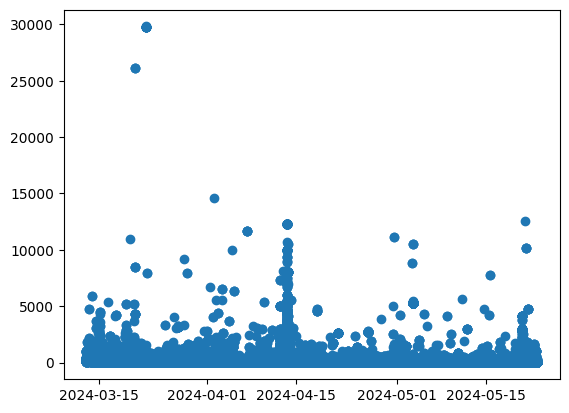

In [106]:
import matplotlib.pyplot as plt
plt.scatter(int_df.index[:TRAIN_SIZE], y_train)